# Machine learning style preprocessing with lightkurve

Machine learning offers interesting avenues for automated lightcurve classification, and complex regression tasks.  The key idea is to hand a pile of data to a black box algorithm that learns labels on training data through gradient descent optimization, while mitigating overfitting by checking classification performance against held-out test data.  

Machine learning algorithms work best when data are "clean", or devoid of missing values and spurious noise.  Data scientists and machine learning practitioners often quip that data preparation, cleaning, and preprocessing can occupy a large fraction of a machine learning project, so making this step easier will help facilitate machine learning projects.

In this tutorial we replicate the machine learning *Input Representations* of Kepler lightcurves described by [Shallue & Vanderburg 2018](https://ui.adsabs.harvard.edu/abs/2018AJ....155...94S/abstract):

> We generate a **global view** of the light curve [...]  All light curves are binned to the same length

> We generate a **local view** of the transit [...] so that the transit occupies a fixed fraction of the resulting vector. 

The section concludes with a normalization procedure to make the transits all the same depth:

> ...we normalize all light curves to have median 0 and minimum value –1 so that all TCEs have a fixed transit depth.

The global view has a fixed length of 2001 bins, while the local view has a fixed length of 201 bins.

This tutorial requires version 1.5 or greater of `lightkurve`, which added new binning features that offer more flexibility and user-control of where and how to assign bins.

In [1]:
%matplotlib inline
import lightkurve as lk
import numpy as np

Let's look at exoplanet host star KIC 757450, which has a period of $P=8.88492\;d$, $T_0=134.452\;d$, and transit duration $2.078$ hours.

In [2]:
lcs = lk.search_lightcurve('KIC 757450', author='Kepler', cadence='long').download_all()

In [3]:
period, t0, duration_hours = 8.88492, 134.452, 2.078

We can stitch all of the quarters together in one fell swoop.

In [4]:
lc_raw = lcs.stitch()
lc_raw.flux.shape

(65031,)

Clean outliers, but only those that are above the mean level (e.g. attributable to stellar flares or cosmic rays).

In [5]:
lc_clean = lc_raw.remove_outliers(sigma=20, sigma_upper=4)

We have to mask the transit to avoid self-subtraction the genuine planet signal when we flatten the lightcurve.  We have to do a hack to find where the time series should be masked.

In [6]:
temp_fold = lc_clean.fold(period, epoch_time=t0)
fractional_duration = (duration_hours / 24.0) / period
phase_mask = np.abs(temp_fold.phase.value) < (fractional_duration * 1.5)
transit_mask = np.isin(lc_clean.time.value, temp_fold.time_original.value[phase_mask])

Now flatten the mask, but interpolate the trend over the points possessing the transit signal of interest.

In [7]:
lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask)

Now fold the cleaned, flattened lightcurve:

In [8]:
lc_fold = lc_flat.fold(period, epoch_time=t0)

Now let's generate the **global** input representation by binning:

In [9]:
lc_global = lc_fold.bin(time_bin_size=0.005).normalize() - 1
lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1
lc_global.flux.shape

(1777,)

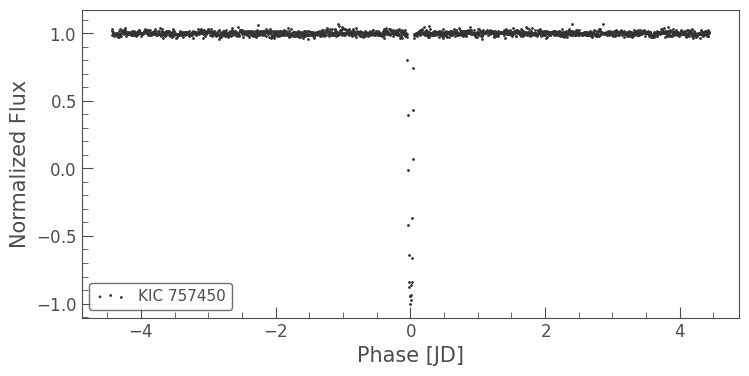

In [10]:
lc_global.scatter();

Excellent!  The pattern matches those seen the original publication figures.  What about the **local** view?  We need to *zoom in* on the transit:

In [11]:
phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration)
lc_zoom = lc_fold[phase_mask]

In [12]:
lc_local = lc_zoom.bin(time_bin_size=0.0005).normalize() - 1
lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)) ) * 2.0 + 1
lc_local.flux.shape

(156,)

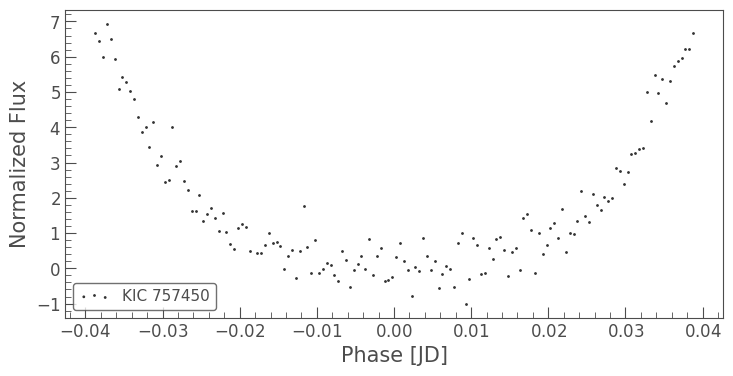

In [13]:
lc_local.scatter();

Voilà!  We've condensed the raw signal of over 65,000 time series data points into two cleaned, simplified input representation using `lightkurve`'s built-in functions.  These views could be passed into a neural network classifier to establish whether the signal is likely to be an exoplanet or not.  